# <center> Лабораторная работа 3
## <center> Задача классификации. Сверточная нейронная сеть
### _Автор: Стецук Максим 1гр.2п.гр._

In [1]:
# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, SpatialDropout2D

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

from keras.regularizers import l2

# модуль для отсчета времени
import time

### <center> _Подготовка данных_

In [3]:
# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '../content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['.DS_Store', 'Выходящий', 'Входящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Удаление файла .DS_Store из списка, если он есть (скрытый файл создаваемый macOS)
if '.DS_Store' in CLASS_LIST:
    CLASS_LIST.remove('.DS_Store')

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса
for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['04354.jpg', '02725.jpg', '00132.jpg', '00654.jpg', '06225.jpg', '02043.jpg', '04432.jpg', '02057.jpg', '05738.jpg', '04426.jpg', '03349.jpg', '00640.jpg', '00898.jpg', '06231.jpg', '01238.jpg', '00126.jpg', '04340.jpg', '02731.jpg', '01210.jpg', '03407.jpg', '04368.jpg', '05076.jpg', '02719.jpg', '05710.jpg', '03361.jpg', '00668.jpg', '06219.jpg', '01576.jpg', '01562.jpg', '05704.jpg', '03375.jpg', '03413.jpg', '05062.jpg', '01204.jpg', '05089.jpg', '04397.jpg', '05937.jpg', '02080.jpg', '01589.jpg', '00697.jpg', '00683.jpg', '05923.jpg', '02094.jpg', '04383.jpg', '02902.jpg', '00873.jpg', '00867.jpg', '02916.jpg', '04630.jpg', '02241.jpg', '01748.jpg', '06027.jpg', '01990.jpg', '00456.jpg', '00330.jpg', '02527.jpg', '05248.jpg', '04156.jpg', '03639.jpg', '02533.jpg', '04142.jpg', '00324.jpg', '06033.jpg', '01984.jpg', '00442.jpg', '04624.jpg', '02255.jpg', '01774.jpg', '03163.jpg', '05512.jpg', '05274.jpg', '03605.jpg', '01012.jpg', '00318.jpg', '01006.jpg', '05260.jpg', 

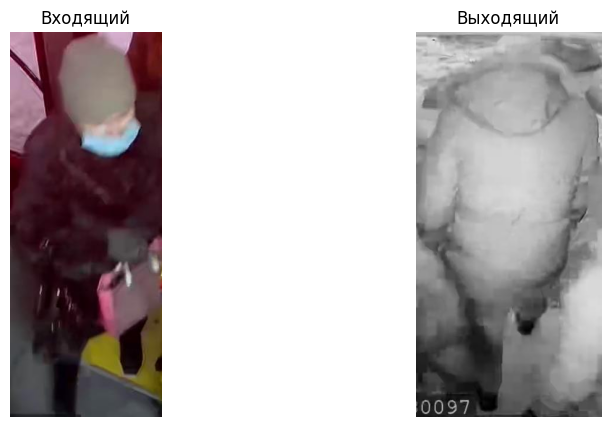

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
# Cписок путей к файлам картинок
data_files = []
# Список меток классов, соответствующих файлам
data_labels = []

for class_label in range(CLASS_COUNT):
    class_name = CLASS_LIST[class_label]
    class_path = IMAGE_PATH + class_name
    class_files = os.listdir(class_path)
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [8]:
# Задание высоты и ширины загружаемых изображений
IMG_HEIGHT = 32
IMG_WIDTH = 64

# Пустой список для данных изображений
data_images = []

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_HEIGHT, IMG_WIDTH)).convert("L")
    img_np = np.array(img)
    data_images.append(img_np) 

x_data = np.array(data_images).reshape(-1,32,64,1)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (64, 32)
Общий массив данных изображений следующей формы: (9081, 32, 64, 1)
Общий массив меток классов следующей формы: (9081,)


In [9]:
# Нормированние массива изображений
x_data = x_data / 255

In [10]:
# задаем желаемый размер изображениям

img_height = 32
img_width = 64
chanels = 1

# вкодные данные
input_shape = (img_height, img_width, chanels)

### <center> _Реализация и обучение модели_

In [11]:
# model = Sequential([
#     Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     BatchNormalization(),
#     Conv2D(64, (3, 3), padding='same', activation='relu'),
#     Conv2D(64, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     BatchNormalization(),
#     Conv2D(128, (3, 3), padding='same', activation='relu'),
#     Conv2D(128, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     BatchNormalization(),
#     Conv2D(256, (3, 3), padding='same', activation='relu'),
#     Conv2D(256, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     BatchNormalization(),
#     SpatialDropout2D(0.5),

#     Flatten(),
#     Dense(512, activation='elu'),
#     BatchNormalization(),
#     Dense(256, activation='elu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='elu'),
#     Dense(2, activation='softmax')
# ])


# model.summary()

# -------------------

# model = Sequential()
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(input_shape)))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(0.5))
# model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(SpatialDropout2D(0.5))
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Flatten())
# model.add(Dense(512, activation='elu'))
# model.add(BatchNormalization())
# model.add(Dense(256, activation='elu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='elu'))
# model.add(Dense(2, activation='softmax'))

# -----------------------

# model = Sequential([
#     Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.4),

#     BatchNormalization(),
#     Conv2D(64, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.4),

#     BatchNormalization(),
#     Conv2D(128, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.4),

#     BatchNormalization(),
#     Conv2D(256, (3, 3), padding='same', activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.4),

#     Flatten(),
#     Dense(256, activation='elu'),
#     Dropout(0.5),
#     BatchNormalization(),
#     Dense(128, activation='elu'),
#     Dropout(0.5),
#     BatchNormalization(),
#     Dense(64, activation='elu'),
#     Dropout(0.5),
#     Dense(32, activation='elu'),
#     Dense(2, activation='softmax')
# ])


# model.summary()


# ----------------------

# model = Sequential([
    
#     MaxPooling2D(pool_size=(2, 2)),Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=L1L2(0.0001, 0.001)),
#     SpatialDropout2D(0.6),

#     BatchNormalization(),
#     Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     BatchNormalization(),
#     Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     BatchNormalization(),
#     Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     MaxPooling2D(pool_size=(2, 2)),
#     SpatialDropout2D(0.5),

#     Flatten(),
#     Dense(256, activation='elu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     BatchNormalization(),
#     Dense(128, activation='elu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     Dropout(0.5),
#     BatchNormalization(),
#     Dense(64, activation='elu', kernel_regularizer=L1L2(0.0001, 0.001)),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])


# model.summary()

# model = Sequential()

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(SpatialDropout2D(0.4))

# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(SpatialDropout2D(0.4))

# model.add(BatchNormalization())
# model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
# model.add(Dropout(0.2))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(SpatialDropout2D(0.4))

# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(256, activation='elu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(128, activation='elu'))
# model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='elu'))
# model.add(Dropout(0.4))
# model.add(Dense(32, activation='elu'))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

#--------------------------

# 80 percant
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(input_shape)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.2),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.3),
    
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.4),
    
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])



# model.summary()

# ---------------------

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),  # Увеличим dropout
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.35),  # Увеличим dropout
    
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.45),  # Увеличим dropout
    
#     Flatten(),
#     Dense(512, activation='relu', kernel_regularizer=L2(0.001)),  # Добавим L2-регуляризацию
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])





# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(input_shape)),
#     BatchNormalization(),
#     Conv2D(32, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.25),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.35),
    
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.45),
    
#     Flatten(),
#     Dense(512, activation='elu'),
#     BatchNormalization(),
#     Dense(256, activation='elu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(128, activation='elu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])

#----------------------

# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(input_shape), kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.5),
    
#     Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.5),
    
#     Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(0.5),
    
#     Flatten(),
#     Dense(512, activation='relu', kernel_regularizer=l2(0.0001)),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(2, activation='softmax')
# ])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 16, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 16, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 16, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,388,962 (9.11 MB)

 Trainable params: 2,387,042 (9.11 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 129ms/step - accuracy: 0.5445 - loss: 1.0947 - val_accuracy: 0.0000e+00 - val_loss: 1.4411
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 136ms/step - accuracy: 0.6700 - loss: 0.7393 - val_accuracy: 0.2350 - val_loss: 1.1556
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.7811 - loss: 0.4873 - val_accuracy: 0.2999 - val_loss: 1.3362
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 32s 140ms/step - accuracy: 0.8298 - loss: 0.3919 - val_accuracy: 0.3060 - val_loss: 1.5056
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 32s 142ms/step - accuracy: 0.8645 - loss: 0.3128 - val_accuracy: 0.3027 - val_loss: 1.6016
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 30s 134ms/step - accuracy: 0.8936 - loss: 0.2639 - val_accuracy: 0.4425 - val_loss: 1.2603
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.9178 - loss: 0.2170 - val_accuracy: 0.4744 - val_loss: 1.3430
Epoch 8/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 31s 137ms/step - accuracy: 0.92

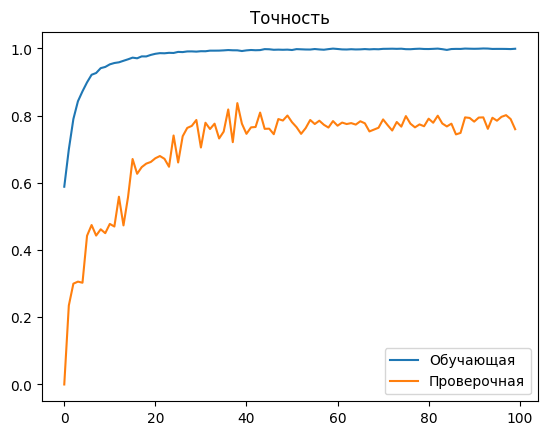

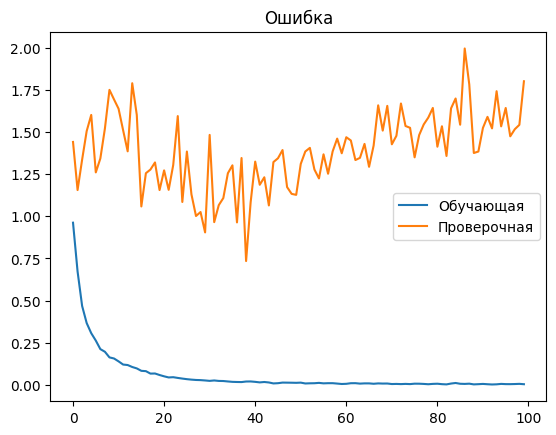

In [12]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

store = model.fit(x_data,
                  y_data,
                  shuffle=True,
                  epochs=100,
                  validation_split=0.2,
                  verbose=1)
plt.plot(store.history['accuracy'], label='Обучающая')
plt.plot(store.history['val_accuracy'], label='Проверочная')
plt.legend()
plt.title('Точность')
plt.show()
plt.plot(store.history['loss'], label='Обучающая')
plt.plot(store.history['val_loss'], label='Проверочная')
plt.legend()
plt.title('Ошибка')
plt.show()